<a href="https://colab.research.google.com/github/antonysamuel/Article-Datasets/blob/main/VariationalAutoEncoder%7C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/rasbt/stat453-deep-learning-ss21

Cloning into 'stat453-deep-learning-ss21'...
remote: Enumerating objects: 1085, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 1085 (delta 6), reused 4 (delta 4), pack-reused 1050
Receiving objects: 100% (1085/1085), 114.72 MiB | 37.38 MiB/s, done.
Resolving deltas: 100% (110/110), done.


In [3]:
%cd /content/stat453-deep-learning-ss21/L17

/content/stat453-deep-learning-ss21/L17


In [4]:
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [5]:
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50

Device: cuda:1


In [6]:
set_deterministic
set_all_seeds(RANDOM_SEED)

In [7]:
train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    validation_fraction=0.)

100%|██████████| 9912422/9912422 [00:00<00:00, 100033711.91it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 120055197.05it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26512498.93it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20309732.16it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [8]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


In [12]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(3136, 2)
        self.z_log_var = torch.nn.Linear(3136, 2)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [15]:

set_all_seeds(RANDOM_SEED)

model = VAE()
model.to('cuda')

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [17]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device='cuda', 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/050 | Batch 0000/0234 | Loss: 183.9377
Epoch: 001/050 | Batch 0050/0234 | Loss: 57.0058
Epoch: 001/050 | Batch 0100/0234 | Loss: 51.7439
Epoch: 001/050 | Batch 0150/0234 | Loss: 51.3792
Epoch: 001/050 | Batch 0200/0234 | Loss: 49.2761
Time elapsed: 0.70 min
Epoch: 002/050 | Batch 0000/0234 | Loss: 48.0166
Epoch: 002/050 | Batch 0050/0234 | Loss: 45.1878
Epoch: 002/050 | Batch 0100/0234 | Loss: 44.0954
Epoch: 002/050 | Batch 0150/0234 | Loss: 43.1013
Epoch: 002/050 | Batch 0200/0234 | Loss: 43.3697
Time elapsed: 1.29 min
Epoch: 003/050 | Batch 0000/0234 | Loss: 43.0041
Epoch: 003/050 | Batch 0050/0234 | Loss: 41.1604
Epoch: 003/050 | Batch 0100/0234 | Loss: 42.8458
Epoch: 003/050 | Batch 0150/0234 | Loss: 41.5584
Epoch: 003/050 | Batch 0200/0234 | Loss: 41.4407
Time elapsed: 1.89 min
Epoch: 004/050 | Batch 0000/0234 | Loss: 41.6408
Epoch: 004/050 | Batch 0050/0234 | Loss: 40.2096
Epoch: 004/050 | Batch 0100/0234 | Loss: 39.7560
Epoch: 004/050 | Batch 0150/0234 | Loss: 40.6961

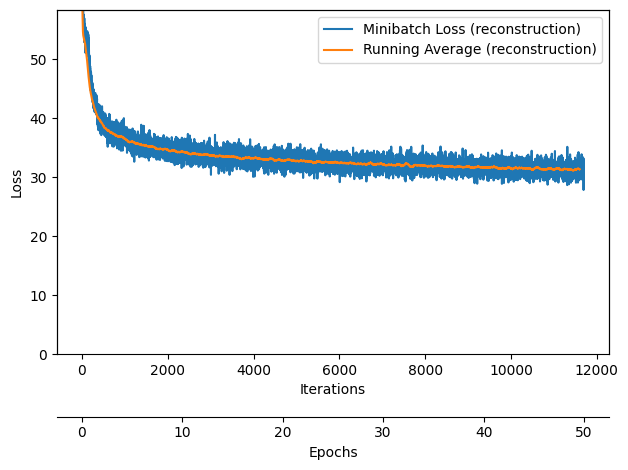

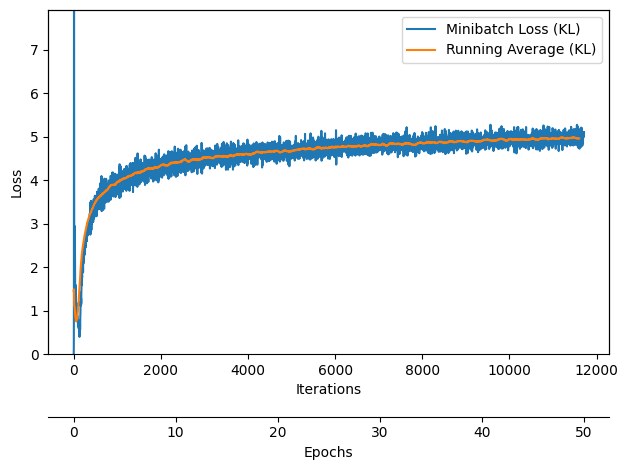

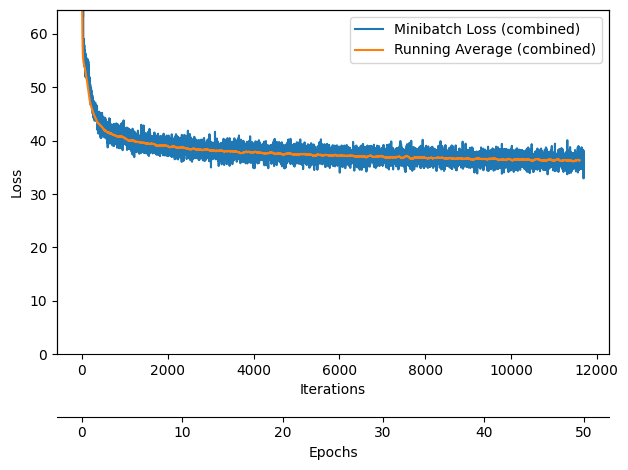

In [18]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

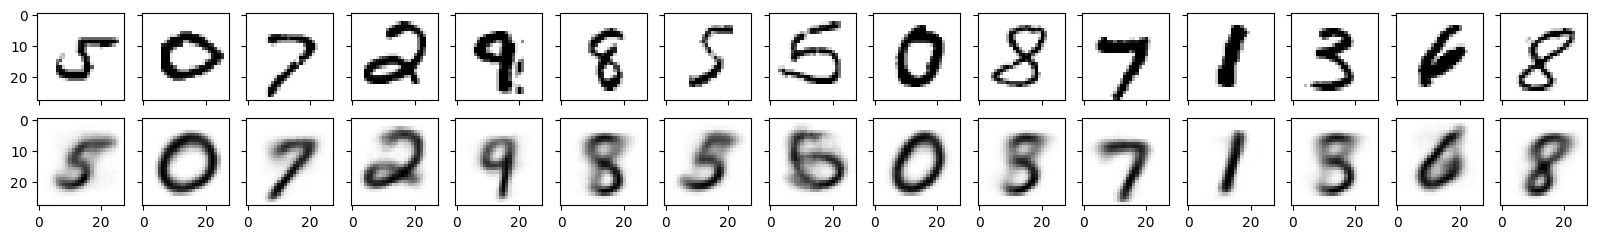

In [20]:
plot_generated_images(data_loader=train_loader, model=model, device='cuda', modeltype='VAE')           


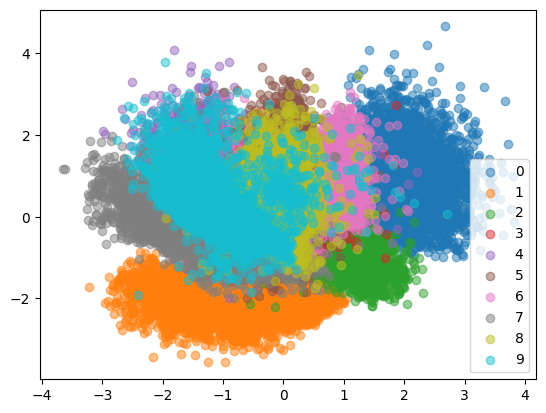

In [23]:
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn, 
    device='cuda')

plt.legend()
plt.show()

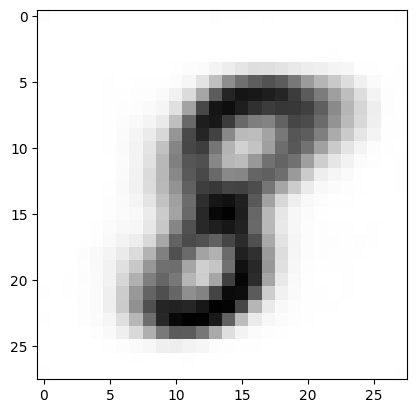

In [25]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-0.0, 0.03]).to('cuda'))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

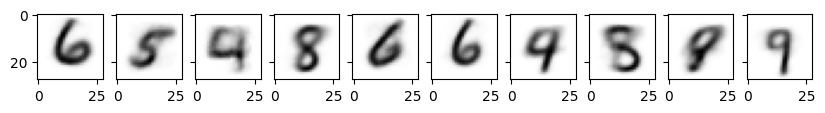

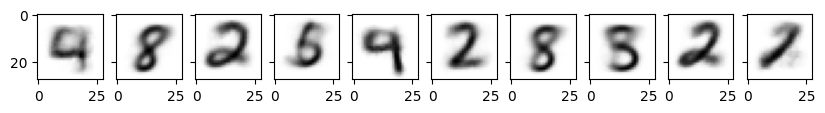

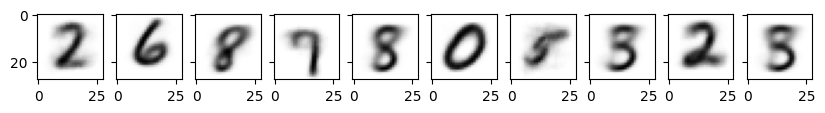

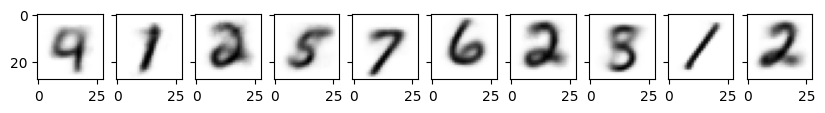

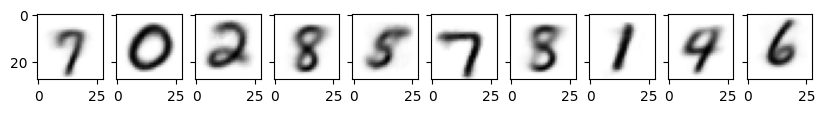

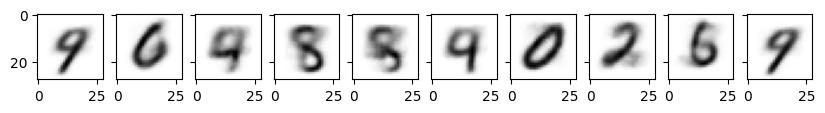

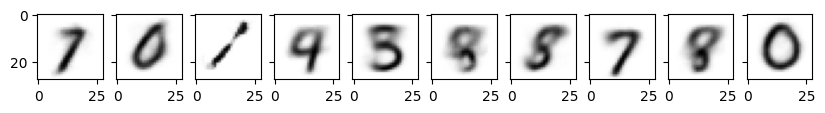

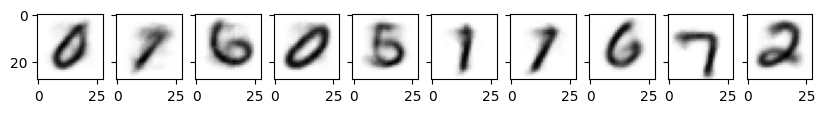

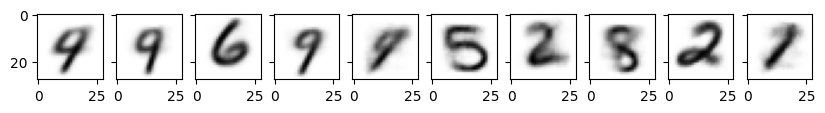

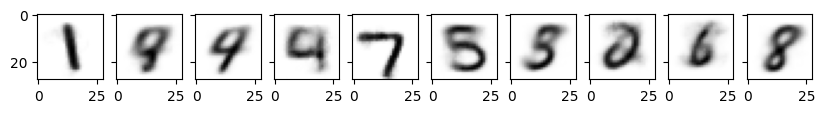

In [27]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device='cuda', latent_size=2)
    plt.show()